<a href="https://colab.research.google.com/github/SzymonNowakowski/ml_workshop_jupyter/blob/main/3_simple_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this workshop, we will dive into a construction of a simple MultiLayer Perceptron neural network. A MultiLayer Perceptron, also termed MLP, is a simple network consisting of a few fully connected linear layers

![MLP - image from https://www.researchgate.net/publication/341626283_Prioritizing_and_Analyzing_the_Role_of_Climate_and_Urban_Parameters_in_the_Confirmed_Cases_of_COVID-19_Based_on_Artificial_Intelligence_Applications](https://i.imgur.com/8cw4GD3.png)

Linear layers must be separated by nonlinear components (also called *activation functions*).

![non-linear components - image from https://www.simplilearn.com/tutorials/deep-learning-tutorial/perceptron](https://imgur.com/L3YxcSs.png)

### Your task #1

What is the purpose of the non-linearities in-between the layers of the neural network?

### Answers to task #1
A nonlinear component in-between the linear layers is essential:
1. without it, a compostion of linear components would be just a linear component, so a multilayer network would be equivalent to a single layered network.
2. it is a nonlinear component that enables a neural network to express nonlinear functions, too.

In this workshop, we will construct an MLP network designed to a specific task of classification of MNIST dataset: a set of handwritten digits from *zero* to *nine*. MNIST stands for Modified National Institute of Standards and Technology database.

**You can read more about this dataset [here](https://colah.github.io/posts/2014-10-Visualizing-MNIST/#MNIST).**

# Mathematically oriented notation for the MLP

A three layer perceptron we will work further with in this workshop can be defined in a mathematematically apealing way as

$f:\mathbb{R}^{28\cdot 28 + D} \rightarrow \mathbb{R}^{10}$ defined as

$f \left(x; W_1, W_2, W_3, W_4, b_1, b_2, b_3, b_4 \right) =  W_4 \left[ W_3 \left[ W_2 \left[ W_1 x  + b_1 \right]_+  + b_2 \right]_+  + b_3 \right]_+ + b_4$,

where matrices $W_1, \ldots, W_4$ are tensors of order two (matrices) with matching dimensions and bias terms $b_1, \ldots, b_4$ are tensors of order one (vectors) of matching dimensions, and $\left[ \cdot \right]_+$ is taking a positive part, which is another notation for ReLU.

Note, that there is no nonlinear activation after the third layer in our neural network. **There is an implicit softmax applied while cross entropy loss is calculated by `torch.nn.functional`.**

# Automatic gradient

The [automatic gradient functionality covered in another workshop](https://github.com/SzymonNowakowski/ml_workshop_jupyter/blob/main/1_computational_graph.ipynb) will be used to automatically calculate
gradient of
$loss \left(f \left(x; W_1, W_2, W_3, W_4, b_1, b_2, b_3, b_4 \right), y_i\right)$ for the training set $\left(x_i, y_i \right)_{i=1, \ldots, N}$
with respect to each component of $W_i$ and $b_i$ tensors.

The training set will be batched, but it is just a technical detail.

# Loss

For the loss function we will use a crossentropy loss directly from PyTorch functional library `torch.nn.functional`. You can read more about this loss [in PyTorch documentation about CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) or generally in [`torch.nn.functional` loss functions section](https://pytorch.org/docs/2.1/nn.functional.html#loss-functions).

### Workshop dedicated to loss functions

**Also, [there is a workshop dedicated to loss functions](https://github.com/SzymonNowakowski/ml_workshop_jupyter/blob/main/2_loss_functions.ipynb)**.

In [1]:
import torch
import torchvision
from matplotlib import pyplot

### Reading MNIST data set

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)

100%|██████████| 9912422/9912422 [00:00<00:00, 179248146.09it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 37456924.50it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41615617.51it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20957677.41it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



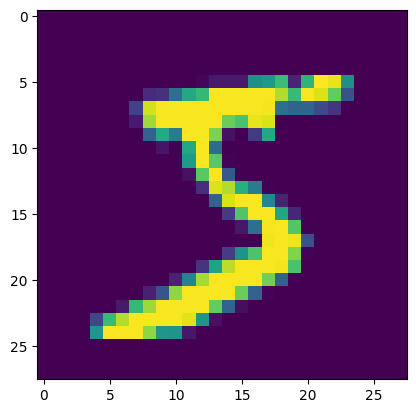

In [3]:
train_image, train_target = trainset[0]    #let us examine the 0-th sample
pyplot.imshow(train_image)
pyplot.show()

In [4]:
trainset.data[0]     #it will be shown in two rows, so a human has hard time classificating it

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [5]:
trainset[0][1]    #check if you classified it correctly in your mind

5


### Your task #2

Examine a few more samples from mnist dataset. Try to guess the correct class correctly, classifing images with your human classification skills. Try to estimate the accuracy, i.e. what is your percentage of correct classifications - treating a training set that we are examining now as a test set for you. It is sound, because you have not trained on that set before attempting the classification.


### Your task #3

Try to convert the dataset into numpy `ndarray`. Then estimate mean and standard deviation of MNIST dataset. Please remember that it is customary to first divide each value in MNIST dataset by 255, to normalize the initial pixel RGB values 0-255 into (0,1) range.

*Tips:*
- to convert MNIST dataset to numpy, use `trainset.data.numpy()`
- in numpy, there are methods `mean()` and `std()` to calculate statistics of a vector.

In [6]:
(trainset.data.numpy().mean()/255.0, trainset.data.numpy().std()/255.0)   #MNIST datapoints are RGB integers 0-255

(0.1306604762738429, 0.30810780385646264)

Now, we will reread the dataset (**train** and **test** parts) and transform it (standardize it) so it will be zero-mean and unit-std.

In [7]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=2048, shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

Let us visualise the training labels

In [8]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i<5:
            print(i, "-th batch labels :", batch_labels)

0 -th batch labels : tensor([1, 7, 9,  ..., 0, 7, 4])
1 -th batch labels : tensor([0, 5, 4,  ..., 7, 4, 1])
2 -th batch labels : tensor([7, 4, 9,  ..., 6, 7, 0])
3 -th batch labels : tensor([9, 2, 4,  ..., 8, 0, 1])
4 -th batch labels : tensor([1, 8, 5,  ..., 2, 3, 0])



### Your taks #4

A single label is an entity of order zero (a constant), but batched labels are of order one. The first (and only) index is a sample index within a batch.

Your task is to visualise and inspect the number of orders in data in batch_inputs.

In [9]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i==0:
            print(i, "-th batch inputs :", batch_inputs)

0 -th batch inputs : tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
     

OK, so each data image was initially a two dimensional image when we first saw it, but now the batches have order 4. The first index is a sample index within a batch, but a second index is always 0. This index represents a Channel number inserted here by ToTensor() transformation, always 0. As this order is one-dimensional, we can get rid of it, later, in training, in `Flatten()` layer or by using `squeeze()` on a tensor.

### MLP

Now, a definition of a simple MLP network.

In [10]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way,
                                          #that output from a preceding layer serves as input to the next layer
            torch.nn.Flatten(),   #change the last three orders in data (with dimensions 1, 28 and 28 respectively) into one order of dimensions (1*28*28)
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 256),
            torch.nn.ReLU(),            #ReLU (or a Sigmoid if you want) is a nonlinear function which is used in-between layers
            torch.nn.Linear(256, 10),
        )
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x

### Training

Training consists of
- an initiation of a network
- a definition of an optimizer. Optimizer does a gradient descent on gradients computed in a `backward()` step on a loss.
- running through multiple epochs and updating the network weights

In [11]:
net = MLP()
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001. We will be using ADAM optimizer throughout the workshop
                                                        #different choices are possible, but this is outside the scope of this workshop

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data
        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOES NOT improve, meaning that the network doesn't update


epoch: 0 batch: 0 current batch loss: 2.3068065643310547
epoch: 0 batch: 1 current batch loss: 2.0909082889556885
epoch: 0 batch: 2 current batch loss: 1.6373933553695679
epoch: 0 batch: 3 current batch loss: 1.1119616031646729
epoch: 0 batch: 4 current batch loss: 0.997447669506073
epoch: 0 batch: 5 current batch loss: 1.2922513484954834
epoch: 0 batch: 6 current batch loss: 1.3425639867782593
epoch: 0 batch: 7 current batch loss: 1.1184653043746948
epoch: 0 batch: 8 current batch loss: 0.6982258558273315
epoch: 0 batch: 9 current batch loss: 0.704410970211029
epoch: 0 batch: 10 current batch loss: 0.7593024373054504
epoch: 0 batch: 11 current batch loss: 0.6717523336410522
epoch: 0 batch: 12 current batch loss: 0.6541317701339722
epoch: 0 batch: 13 current batch loss: 0.5578519105911255
epoch: 0 batch: 14 current batch loss: 0.5410290360450745
epoch: 0 batch: 15 current batch loss: 0.5218665599822998
epoch: 0 batch: 16 current batch loss: 0.473332941532135
epoch: 0 batch: 17 current 


### Your task #5

Comment the line `optimizer.step()` above. Rerun the above code. Note that the loss is NOT constant as the comment in the code seems to promise, but anyway, the loss doesn't improve, either. Please explain, why the loss is not constant. Please explain, why the loss doesn't improve, either.

An epoch is a one full passage through the whole training data. Why then, on the second epoch, the losses are different than in the first epoch?

### Answers to task #5

The loss is not constant because in our code we are printing losses in batches, and each batch is a different data sample. A loss value calculated on different data sample may be different. Moreover, the second epoch and subsequent epochs, i.e. next runs through the whole data, they consist of different randomly shuffled batches, because we selected `shuffle = True` when initiating a training dataset. It means, that even in next epochs, batched samples will be different samples and the loss values may differ.

But overall, loss desn't improve because the weights in the network do not change. The line responsible for changing the weights in the network is commented.

### Training - the second approach


Sometimes during training loss stabilizes and doesn't improve anymore. It is not the case here (yet, but we have only run 8 epochs), but a real problem in practice.
We can include a new tool called a **scheduler** that would update the *learning rate* in an otpimizer after each epoch. This usually helps the training. Let us reformulate the traning so it consists of
- an initiation of a network
- a definition of an optimizer. Optimizer does a gradient descent on gradients computed in a `backward()` step on a loss.
- a definition of a scheduler to update the learning rate in an optimizer
- running through multiple epochs and updating the network weights

In [12]:
net_with_scheduler = MLP()
optimizer = torch.optim.Adam(net_with_scheduler.parameters(), 0.001)   #initial learning rate of 0.001.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)    #updates the learning rate after each epoch. There are many ways to do that: StepLR multiplies learning rate by gamma

net_with_scheduler.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data
        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net_with_scheduler(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function

        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item(), "current lr:", scheduler.get_last_lr()[0])
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.

    scheduler.step()

epoch: 0 batch: 0 current batch loss: 2.3059325218200684 current lr: 0.001
epoch: 0 batch: 1 current batch loss: 2.078433036804199 current lr: 0.001
epoch: 0 batch: 2 current batch loss: 1.6184415817260742 current lr: 0.001
epoch: 0 batch: 3 current batch loss: 1.1510072946548462 current lr: 0.001
epoch: 0 batch: 4 current batch loss: 1.0691945552825928 current lr: 0.001
epoch: 0 batch: 5 current batch loss: 1.0500121116638184 current lr: 0.001
epoch: 0 batch: 6 current batch loss: 1.1987625360488892 current lr: 0.001
epoch: 0 batch: 7 current batch loss: 0.8782199621200562 current lr: 0.001
epoch: 0 batch: 8 current batch loss: 0.7880807518959045 current lr: 0.001
epoch: 0 batch: 9 current batch loss: 0.8341243267059326 current lr: 0.001
epoch: 0 batch: 10 current batch loss: 0.7004535794258118 current lr: 0.001
epoch: 0 batch: 11 current batch loss: 0.6361493468284607 current lr: 0.001
epoch: 0 batch: 12 current batch loss: 0.5678898692131042 current lr: 0.001
epoch: 0 batch: 13 curr


### Your task #6

Well, it seems that we were able to get the learning to levels of 0.03 even without a scheduler. Can you bring it under 0.02? Can you keep it under 0.02? The scheduler didn't help much. Maybe the proposed gamma was to low (0.9 only)? Please experiment with different settings for the optimizer learning rate and different scheduler settings. There are other schedulers you can experiment with, too. Please verify what would happen if the nets were allowed to train for more training epochs.

**Some other schedulers you might want to experiment with:**
- Exponential LR - decays the learning rate of each parameter group by gamma every epoch - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html)
- Step LR - more general then the Exponential LR: decays the learning rate of each parameter group by gamma every step_size epochs - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)
- Cosine Annealing LR - learning rate follows the first quarter of the cosine curve - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html)
- Cosine with Warm Restarts - learning rate follows the first quarter of the cosine curve and restarts after a predefined number of epochs - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html)


### Your task #7

Please explain, what are the dangers of bringing the loss too low? What is an *overtrained* neural network? How can one prevent it?

### Testing

Now we will test those two nets - the one without and the one with the scheduler.

In [13]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint)                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9816


In [14]:
good = 0
wrong = 0

net_with_scheduler.eval()   #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():       #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1

        datapoint, label = data

        prediction = net_with_scheduler(datapoint)                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)                   #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9824


Well, not bad. Now it is your turn to experiment - change the number and sizes of layers in out neural networks, change the activation function, play with the learning rate and the optimizer and the scheduler.